In [1]:
#import libraries
import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')
from keras import backend as K
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from keras.models import Model
from keras.layers import Input, Dense, Embedding, MaxPooling1D, Conv1D, SpatialDropout1D
from keras.layers import add, Dropout, PReLU, BatchNormalization, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import optimizers
from keras import initializers, regularizers, constraints, callbacks

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

from statistics import mean
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import Dense, Input, LSTM,GlobalMaxPool1D

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import  precision_score
from sklearn.metrics import  f1_score

/home/amiangshu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/amiangshu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/amiangshu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/amiangshu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
##calculating ROC evaluation
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch + 1, score))

In [3]:
#import embedding files
EMBEDDING_word2vec= '../Embedding_Vecrots/GoogleNews-vectors-negative300.bin'
EMBEDDING_FastText = '../Embedding_Vecrots/crawl-300d-2M.vec'
EMBEDDING_GloVe= '../Embedding_Vecrots/glove.840B.300d.txt'

In [4]:
##import train 

train =pd.read_excel('../Models/code-review-dataset-full.xlsx')
#test =pd.read_excel('./Models/test.xlsx')

X_train = train["message"].fillna("fillna").values
y_train = train[["is_toxic"]].values

In [5]:
## set features
#max_features = 30499
max_features =17401
maxlen = 200
embed_size = 300

In [6]:
## some preprocessing
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
#X_test = tokenizer.texts_to_sequences(X_test)

x_train = sequence.pad_sequences(X_train, maxlen=maxlen)

In [7]:
## applying the embedding vector
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')


embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FastText))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=4, inter_op_parallelism_threads=4)
K.set_session(tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf))

In [8]:
#import k-fold
from sklearn.model_selection import KFold
num_folds = 2

run_precision = []
run_recall = []
run_f1score = []
run_accuracy = []


# model
# wrote out all the blocks instead of looping for simplicity
filter_nr = 64
filter_size = 3
max_pool_size = 3
max_pool_strides = 2
dense_nr = 256
spatial_dropout = 0.2
dense_dropout = 0.5
train_embed = False
conv_kern_reg = regularizers.l2(0.00001)
conv_bias_reg = regularizers.l2(0.00001)

In [9]:
def get_model_PooledGRU():
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(1, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     5220300     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 200, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 200, 160)     182880      spatial_dropout1d_1[0][0]       

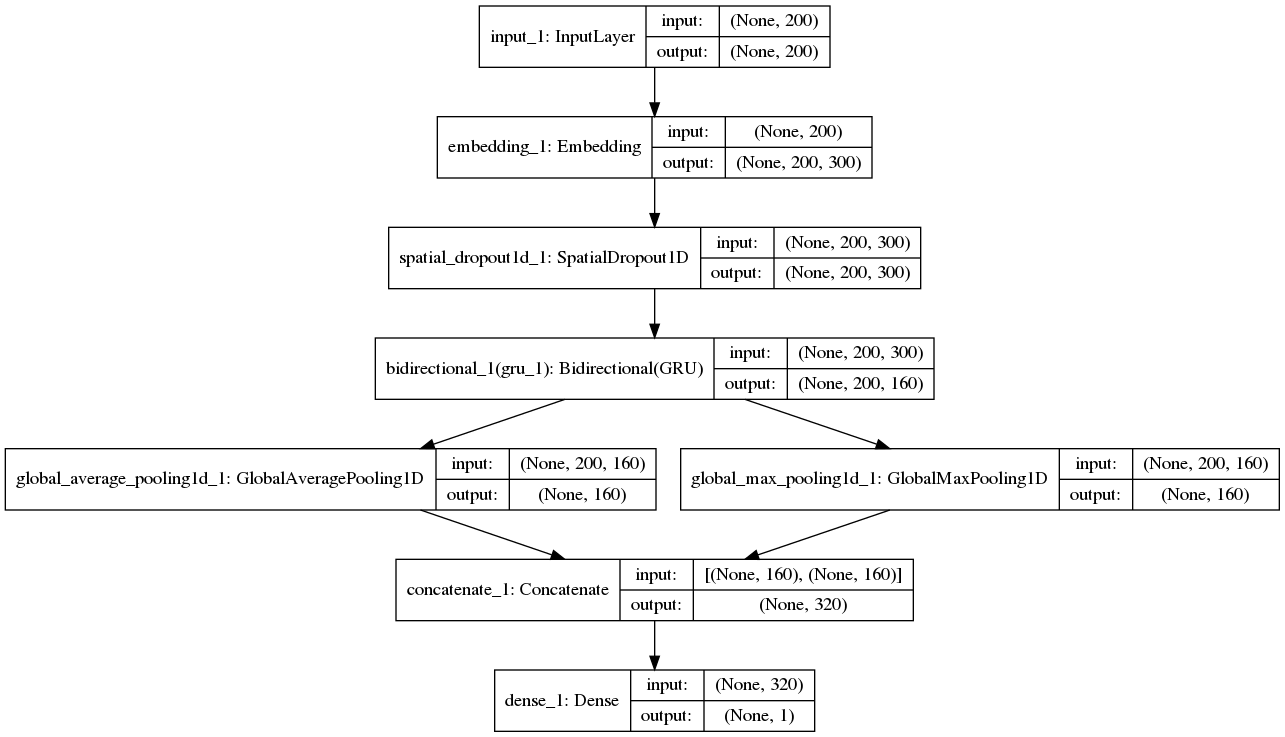

In [10]:
gru_model= get_model_PooledGRU()
from keras.utils.vis_utils import plot_model

gru_model.summary()
#dpcnn_model.layers
plot_model(gru_model, to_file='GRU.png', show_shapes=True, show_layer_names=True)

Starting Fold:  1
Train on 15655 samples, validate on 1958 samples
Epoch 1/20
15655/15655 [==============================] - 94s 6ms/step - loss: 0.2052 - accuracy: 0.9207 - val_loss: 0.1191 - val_accuracy: 0.9571
Epoch 2/20
15655/15655 [==============================] - 93s 6ms/step - loss: 0.1005 - accuracy: 0.9614 - val_loss: 0.1040 - val_accuracy: 0.9668
Epoch 3/20
15655/15655 [==============================] - 94s 6ms/step - loss: 0.0587 - accuracy: 0.9801 - val_loss: 0.1011 - val_accuracy: 0.9673
Epoch 4/20
15655/15655 [==============================] - 93s 6ms/step - loss: 0.0337 - accuracy: 0.9890 - val_loss: 0.1096 - val_accuracy: 0.9714
Epoch 00004: early stopping
Train: 0.996, Test: 0.971


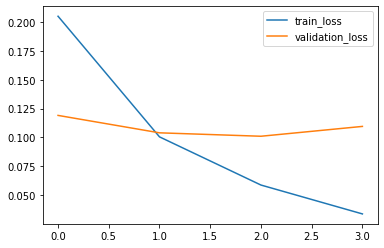

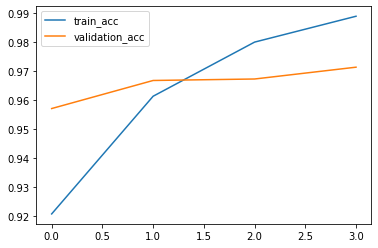

1958/1958 [==============================] - 7s 4ms/step
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1478
           1       0.83      0.77      0.79       480

    accuracy                           0.90      1958
   macro avg       0.88      0.86      0.87      1958
weighted avg       0.90      0.90      0.90      1958

Starting Fold:  2
Train on 15656 samples, validate on 1958 samples
Epoch 1/20
15656/15656 [==============================] - 96s 6ms/step - loss: 0.1988 - accuracy: 0.9215 - val_loss: 0.1206 - val_accuracy: 0.9556
Epoch 2/20
15656/15656 [==============================] - 93s 6ms/step - loss: 0.1010 - accuracy: 0.9616 - val_loss: 0.1066 - val_accuracy: 0.9617
Epoch 3/20
15656/15656 [==============================] - 93s 6ms/step - loss: 0.0587 - accuracy: 0.9805 - val_loss: 0.0972 - val_accuracy: 0.9658
Epoch 4/20
15656/15656 [==============================] - 94s 6ms/step - loss: 0.0335 - accuracy: 0.9892 - v

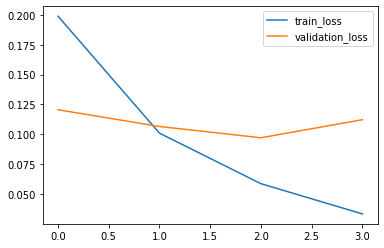

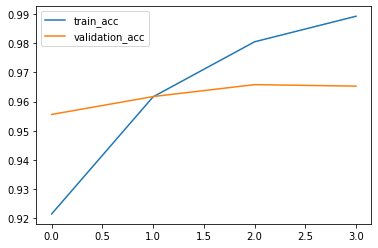

1957/1957 [==============================] - 7s 4ms/step
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1640
           1       0.75      0.69      0.72       317

    accuracy                           0.91      1957
   macro avg       0.85      0.82      0.83      1957
weighted avg       0.91      0.91      0.91      1957

Starting Fold:  3
Train on 15656 samples, validate on 1958 samples
Epoch 1/20
15656/15656 [==============================] - 95s 6ms/step - loss: 0.2008 - accuracy: 0.9182 - val_loss: 0.1173 - val_accuracy: 0.9576
Epoch 2/20
15656/15656 [==============================] - 93s 6ms/step - loss: 0.0958 - accuracy: 0.9640 - val_loss: 0.1002 - val_accuracy: 0.9632
Epoch 3/20
15656/15656 [==============================] - 94s 6ms/step - loss: 0.0538 - accuracy: 0.9819 - val_loss: 0.1017 - val_accuracy: 0.9653
Epoch 00003: early stopping
Train: 0.992, Test: 0.965


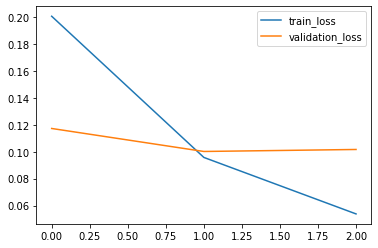

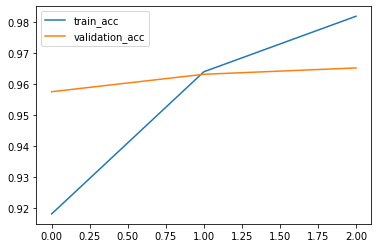

1957/1957 [==============================] - 7s 4ms/step
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1583
           1       0.80      0.61      0.69       374

    accuracy                           0.90      1957
   macro avg       0.85      0.79      0.81      1957
weighted avg       0.89      0.90      0.89      1957

Starting Fold:  4
Train on 15656 samples, validate on 1958 samples
Epoch 1/20
15656/15656 [==============================] - 95s 6ms/step - loss: 0.1983 - accuracy: 0.9204 - val_loss: 0.1273 - val_accuracy: 0.9551
Epoch 2/20
15656/15656 [==============================] - 94s 6ms/step - loss: 0.1057 - accuracy: 0.9571 - val_loss: 0.1206 - val_accuracy: 0.9530
Epoch 3/20
15656/15656 [==============================] - 95s 6ms/step - loss: 0.0670 - accuracy: 0.9752 - val_loss: 0.1255 - val_accuracy: 0.9515
Epoch 00003: early stopping
Train: 0.990, Test: 0.951


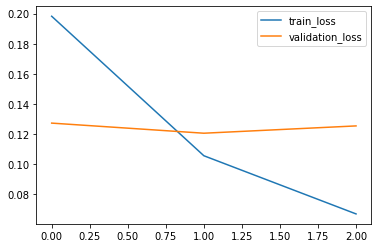

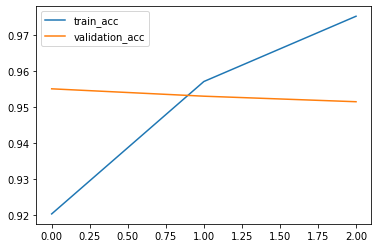

1957/1957 [==============================] - 7s 4ms/step
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1214
           1       0.94      0.92      0.93       743

    accuracy                           0.95      1957
   macro avg       0.95      0.94      0.95      1957
weighted avg       0.95      0.95      0.95      1957

Starting Fold:  5
Train on 15656 samples, validate on 1958 samples
Epoch 1/20
15656/15656 [==============================] - 95s 6ms/step - loss: 0.2158 - accuracy: 0.9112 - val_loss: 0.1322 - val_accuracy: 0.9520
Epoch 2/20
15656/15656 [==============================] - 93s 6ms/step - loss: 0.1137 - accuracy: 0.9536 - val_loss: 0.1199 - val_accuracy: 0.9545
Epoch 3/20
15656/15656 [==============================] - 93s 6ms/step - loss: 0.0718 - accuracy: 0.9748 - val_loss: 0.1331 - val_accuracy: 0.9505
Epoch 00003: early stopping
Train: 0.989, Test: 0.950


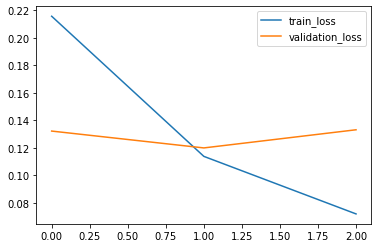

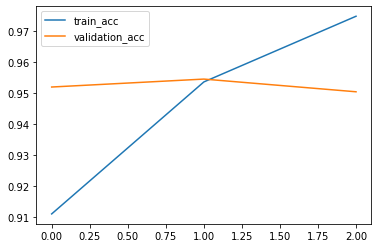

1957/1957 [==============================] - 8s 4ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1557
           1       0.98      0.92      0.95       400

    accuracy                           0.98      1957
   macro avg       0.98      0.96      0.97      1957
weighted avg       0.98      0.98      0.98      1957

Starting Fold:  6
Train on 15656 samples, validate on 1958 samples
Epoch 1/20
15656/15656 [==============================] - 96s 6ms/step - loss: 0.2254 - accuracy: 0.9084 - val_loss: 0.1417 - val_accuracy: 0.9489
Epoch 2/20
15656/15656 [==============================] - 95s 6ms/step - loss: 0.1160 - accuracy: 0.9546 - val_loss: 0.1277 - val_accuracy: 0.9499
Epoch 3/20
15656/15656 [==============================] - 95s 6ms/step - loss: 0.0711 - accuracy: 0.9746 - val_loss: 0.1272 - val_accuracy: 0.9499
Epoch 4/20
15656/15656 [==============================] - 95s 6ms/step - loss: 0.0444 - accuracy: 0.9849 - v

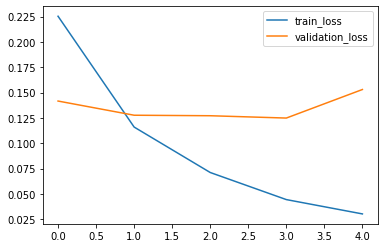

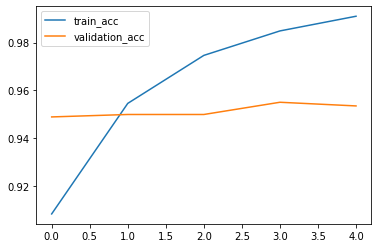

1957/1957 [==============================] - 8s 4ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1756
           1       0.98      0.96      0.97       201

    accuracy                           0.99      1957
   macro avg       0.99      0.98      0.98      1957
weighted avg       0.99      0.99      0.99      1957

Starting Fold:  7
Train on 15656 samples, validate on 1958 samples
Epoch 1/20
15656/15656 [==============================] - 96s 6ms/step - loss: 0.2124 - accuracy: 0.9155 - val_loss: 0.1318 - val_accuracy: 0.9515
Epoch 2/20
15656/15656 [==============================] - 94s 6ms/step - loss: 0.1128 - accuracy: 0.9552 - val_loss: 0.1255 - val_accuracy: 0.9525
Epoch 3/20
15656/15656 [==============================] - 95s 6ms/step - loss: 0.0707 - accuracy: 0.9739 - val_loss: 0.1276 - val_accuracy: 0.9566
Epoch 00003: early stopping
Train: 0.989, Test: 0.957


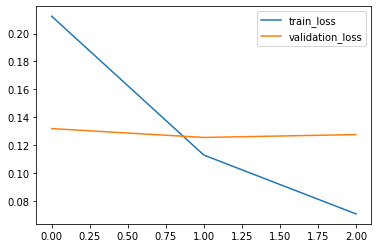

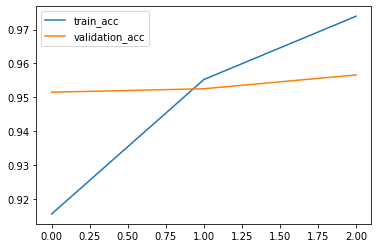

1957/1957 [==============================] - 8s 4ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1585
           1       0.96      0.95      0.96       372

    accuracy                           0.98      1957
   macro avg       0.98      0.97      0.98      1957
weighted avg       0.98      0.98      0.98      1957

Starting Fold:  8
Train on 15656 samples, validate on 1958 samples
Epoch 1/20
15656/15656 [==============================] - 96s 6ms/step - loss: 0.2141 - accuracy: 0.9110 - val_loss: 0.1432 - val_accuracy: 0.9433
Epoch 2/20
15656/15656 [==============================] - 95s 6ms/step - loss: 0.1129 - accuracy: 0.9541 - val_loss: 0.1182 - val_accuracy: 0.9586
Epoch 3/20
15656/15656 [==============================] - 95s 6ms/step - loss: 0.0679 - accuracy: 0.9752 - val_loss: 0.1485 - val_accuracy: 0.9545
Epoch 00003: early stopping
Train: 0.989, Test: 0.955


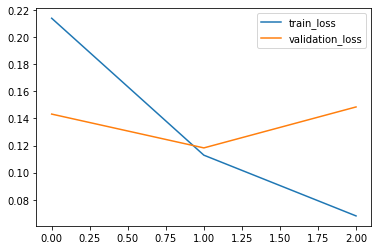

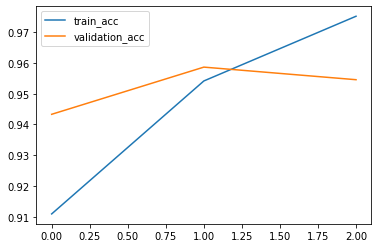

1957/1957 [==============================] - 8s 4ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1434
           1       0.98      0.96      0.97       523

    accuracy                           0.98      1957
   macro avg       0.98      0.98      0.98      1957
weighted avg       0.98      0.98      0.98      1957

Starting Fold:  9
Train on 15656 samples, validate on 1958 samples
Epoch 1/20
15656/15656 [==============================] - 96s 6ms/step - loss: 0.2231 - accuracy: 0.9080 - val_loss: 0.1519 - val_accuracy: 0.9448
Epoch 2/20
15656/15656 [==============================] - 95s 6ms/step - loss: 0.1167 - accuracy: 0.9552 - val_loss: 0.1264 - val_accuracy: 0.9474
Epoch 3/20
15656/15656 [==============================] - 95s 6ms/step - loss: 0.0752 - accuracy: 0.9733 - val_loss: 0.1338 - val_accuracy: 0.9525
Epoch 00003: early stopping
Train: 0.990, Test: 0.953


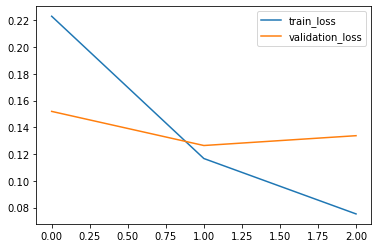

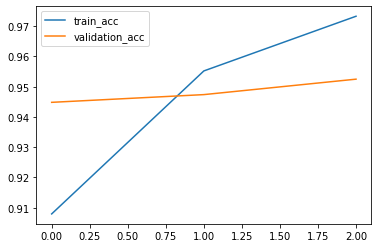

1957/1957 [==============================] - 8s 4ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1669
           1       0.99      0.94      0.97       288

    accuracy                           0.99      1957
   macro avg       0.99      0.97      0.98      1957
weighted avg       0.99      0.99      0.99      1957

Starting Fold:  10
Train on 15656 samples, validate on 1958 samples
Epoch 1/20
15656/15656 [==============================] - 96s 6ms/step - loss: 0.2223 - accuracy: 0.9082 - val_loss: 0.1426 - val_accuracy: 0.9469
Epoch 2/20
15656/15656 [==============================] - 95s 6ms/step - loss: 0.1209 - accuracy: 0.9518 - val_loss: 0.1329 - val_accuracy: 0.9479
Epoch 3/20
15656/15656 [==============================] - 95s 6ms/step - loss: 0.0732 - accuracy: 0.9742 - val_loss: 0.1335 - val_accuracy: 0.9545
Epoch 00003: early stopping
Train: 0.989, Test: 0.955


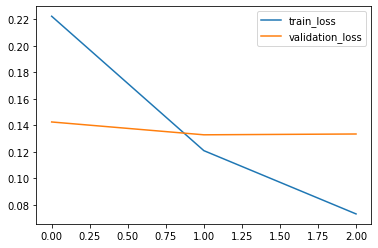

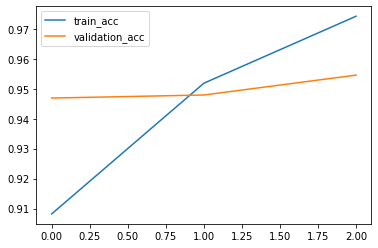

1957/1957 [==============================] - 8s 4ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1903
           1       0.96      0.93      0.94        54

    accuracy                           1.00      1957
   macro avg       0.98      0.96      0.97      1957
weighted avg       1.00      1.00      1.00      1957



In [12]:

from keras.callbacks import EarlyStopping
from matplotlib import pyplot
fold_no = 1

for train_index, test_index in KFold(10).split(x_train):
    gru_model= get_model_PooledGRU()
    
    print("Starting Fold: ", fold_no)
    
    
    x_trn, x_tst = x_train[train_index], x_train[test_index]
    y_trn, y_tst = y_train[train_index], y_train[test_index]
    
    x_new_train, x_val, y_new_train, y_val= train_test_split(x_trn, y_trn, test_size=0.11115, random_state=125)
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1) #added new
    
    history=gru_model.fit(x_new_train,  y_new_train, epochs=20, batch_size=32, validation_data=(x_val, y_val), callbacks=[es]) #added
    
    # evaluate the model
    _, train_acc = gru_model.evaluate(x_new_train,  y_new_train, verbose=0)
    _, val_acc =  gru_model.evaluate(x_val, y_val, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
    #print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    # plot training history
    pyplot.plot(history.history['loss'], label='train_loss')
    pyplot.plot(history.history['val_loss'], label='validation_loss')
    pyplot.legend()
    pyplot.show()
    
     
    # plot training with accuracy
    pyplot.plot(history.history['accuracy'], label='train_acc')
    pyplot.plot(history.history['val_accuracy'], label='validation_acc')
    pyplot.legend()
    pyplot.show() 

    #print("Model Evaluation: ", gru_model.evaluate(x_tst, y_tst))
    
    y_pred =gru_model.predict(x_tst, batch_size=20, verbose=1)
    y_pred = (y_pred >= 0.5)
    
    from sklearn import metrics
    print(metrics.classification_report(y_tst, y_pred))
    
    fold_no = fold_no + 1
    
    precision = precision_score(y_tst, y_pred, pos_label=1)
    recall = recall_score(y_tst, y_pred, pos_label=1)
    f1score = f1_score(y_tst, y_pred, pos_label=1)
    accuracy = accuracy_score(y_tst, y_pred)

    run_accuracy.append(accuracy)
    run_f1score.append(f1score)
    run_precision.append(precision)
    run_recall.append(recall)

In [13]:
print(mean(run_precision),mean(run_recall),mean(run_f1score),mean(run_accuracy)) 

0.9116453765252626 0.854122601155829 0.8810289161605703 0.9541595221204262
